In [1]:
import numpy.random as random
import jax.numpy as np
from tqdm import tqdm
from jax import vmap, grad, jit
import matplotlib.pyplot as plt
from cycler import cycler
import cvxpy as cp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
    #  "contour.negative_linestyle": 'solid',
})
plt.rc('axes', prop_cycle=cycler('linestyle', ['-', '--', ':', '-.']))

In [2]:
# Define problem
random.seed(0)
m, n = 500, 100
A = random.randn(m, n)
b = random.randn(m)

def f(x):
    return np.linalg.norm(np.dot(A, x) - b, 1)


def f_prime(x):
    return np.dot(A.T, np.sign(np.dot(A, x) - b))


# JIT functions for speed
f = jit(f)
f_prime = jit(f_prime)
k_vec = np.arange(6000)

In [3]:
# Solve with cvxpy
x_cp = cp.Variable(n)
f_star = cp.Problem(
    cp.Minimize(cp.norm(A @ x_cp - b, 1))
).solve(solver=cp.ECOS)

In [4]:
# Solve fixed step size
x0 = random.randn(n)
x_hist = {}
subopt_hist = {}

step_sizes = [0.001, 0.0005, 0.0001, 0.00005]
for t in tqdm(step_sizes):
    x_hist[t] = [x0]
    f_best = f(x0)
    subopt_hist[t] = [(f_best - f_star)/f_star]

    for k in k_vec:
        x_next = x_hist[t][-1] - t * f_prime(x_hist[t][-1])
        x_hist[t].append(x_next)
        f_next = f(x_next)
        if f_next < f_best:
            f_best = f_next

        subopt_hist[t].append((f_best - f_star)/f_star)

100%|████████████████████| 4/4 [00:04<00:00,  1.20s/it]


In [5]:
# Solve with fixed-rule step size
step_size_rules = [lambda k: 0.01/np.sqrt(k+1),
                   lambda k: 0.001/np.sqrt(k+1),
                   lambda k: 0.01/(k + 1),
                   ]
step_size_rules_str = [r"$0.01/\sqrt{k+1}$",
                       r"$0.001/\sqrt{k+1}$",
                       r"$0.01/(k+1)$",
                       ]
x_hist_adapt = {}
subopt_hist_adapt = {}
for i, t in enumerate(tqdm(step_size_rules)):
    x_hist_adapt[i] = [x0]
    f_best = f(x0)
    subopt_hist_adapt[i] = [(f_best - f_star)/f_star]

    for k in k_vec:
        x_next = x_hist_adapt[i][-1] - t(k) * f_prime(x_hist_adapt[i][-1])
        x_hist_adapt[i].append(x_next)
        f_next = f(x_next)
        if f_next < f_best:
            f_best = f_next

        subopt_hist_adapt[i].append((f_best - f_star)/f_star)

100%|████████████████████| 3/3 [00:04<00:00,  1.33s/it]


In [7]:
# Solve with polyak step size
x_hist_polyak = [x0]
f_best = f(x0)
f_next = f(x0)
subopt_hist_polyak = [(f_best - f_star)/f_star]
for k in k_vec:
    f_current = f_next
    g = f_prime(x_hist_polyak[-1])
    t = (f_current - f_star) / np.linalg.norm(g)**2
    x_next = x_hist_polyak[-1] - t * g
    x_hist_polyak.append(x_next)
    f_next = f(x_next)
    if f_next < f_best:
        f_best = f_next

    subopt_hist_polyak.append((f_best - f_star)/f_star)

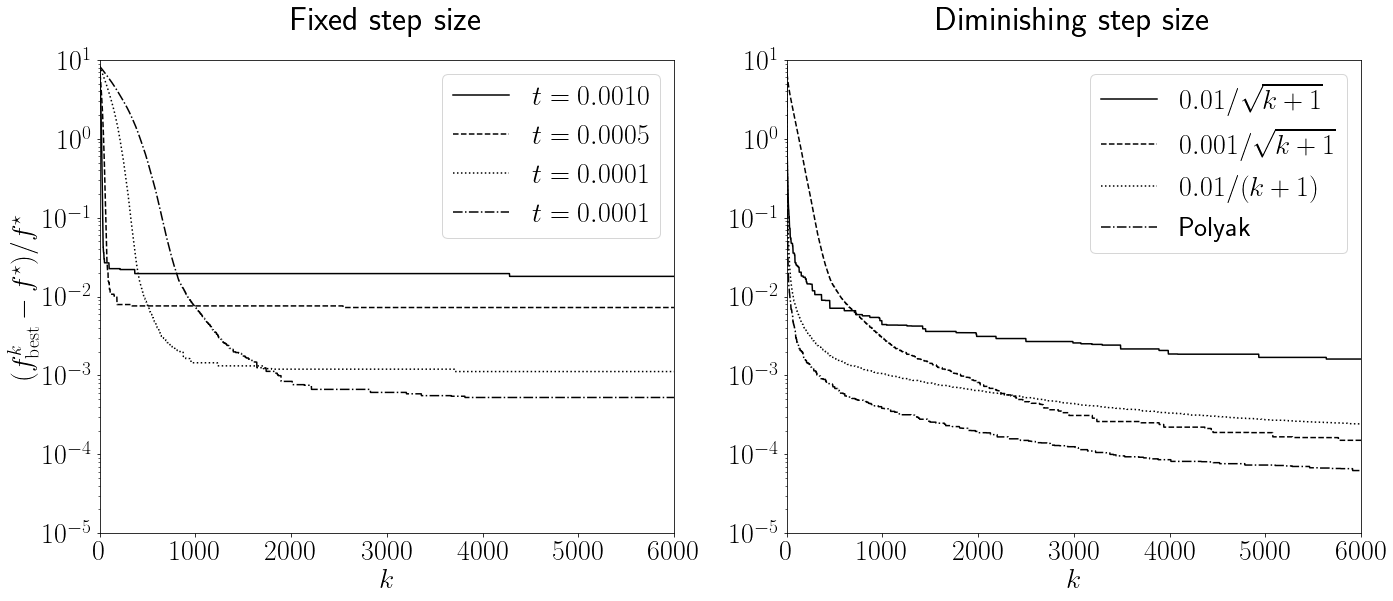

In [8]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(20, 9))

# Fixed step size
for t in step_sizes:
    ax[0].plot(k_vec, subopt_hist[t][:-1], color="k", label=r"$t = %.4f$" % t)
ax[0].set_yscale('log')
ax[0].set_ylabel(r"$(f_{\rm best}^{k} - f^\star)/f^\star$")
ax[0].set_xlabel(r"$k$")
ax[0].set_xlim([0, 6000])
ax[0].set_ylim([1e-05, 1e01])
ax[0].set_title(r"$\mbox{Fixed step size}$", y=1.05)
ax[0].legend()


for i, _ in enumerate(step_size_rules):
    ax[1].plot(k_vec, subopt_hist_adapt[i][:-1], color="k",
               label=step_size_rules_str[i])
ax[1].plot(k_vec, subopt_hist_polyak[:-1], color="k",
           label=r"$\mbox{Polyak}$")
ax[1].set_yscale('log')
#  ax[1].set_ylabel(r"$(f_{\rm best}^{k} - f^\star)/f^\star$")
ax[1].set_xlabel(r"$k$")
ax[1].set_xlim([0, 6000])
ax[1].set_ylim([1e-05, 1e01])
ax[1].set_title(r"$\mbox{Diminishing step size}$", y=1.05)
ax[1].legend()


plt.tight_layout()
plt.savefig("subgradient_method_1norm.pdf")